# 4. The Raster API: titiler-pgstac

titiler-pgstac is the crown jewel of an eoAPI deployment. You can use titiler-pgstac to serve infinitely customizable visualizations of the data in your catalog with just a few lines of code.

### Dynamic Tiling 101
XYZ map tiles are the backbone of web mapping technology. Traditionally, the tile images are generated from the raw data and stored in cloud storage so they can be easily fetched by a map client in a web browser (or desktop GIS application). These tiles are called "static" tiles because they are generated once and cannot be adjusted unless you regenerate the tiles from the raw source.

The static nature of pre-generated tiles is a problem for dynamic datasets like satellite imagery collections where there may be new data streaming in at all times. It is not efficient to be continually rebuilding static tiles for an entire collection when the data are constantly changing!

**Dynamic tiling** provides a solution to this problem. Instead of pre-rendering all of the tile images for a dynamic dataset, dynamic tiling renders the images on-the-fly as they are requested by client applications! Dynamically rendered tile images will take longer to return to the client but, **if the raw data are stored in cloud-optimized data formats**, processing latency will be minimized and you gain the ability to request any visualization configuration (colormap, min/max, band math, expressions, etc).

[titiler](https://developmentseed.org/titiler/) is the state-of-the-art in dynamic tiling. It can take an XYZ tile request, use rasterio/GDAL to read the portion of a data required to render the tile image, then return it to the requester as a .png (or whatever format is requested).

[titiler-pgstac](https://stac-utils.github.io/titiler-pgstac/latest/) extends the core titiler functionality by providing a query interface for a `pgstac` database, allowing users to request visualizations of entire collections or mosaics of items that are in their STAC.

To illustrate the power of titiler-pgstac, consider the following examples:
1. You can create an interactive map with the most recent Sentinel-2 images from your STAC collection in just a few lines of code
2. You can create an interacive map with the most recent **cloud-free** images from any period of time in the archive with 10 lines of code
3. You can view natural color and false color composites of the imagery with one small change

You can do all of this with titiler-pgstac with a single copy of the raw data in cloud storage!

Start by entering the username you picked when defining your personal Sentinel-2 L2A collection:

In [5]:
import ipywidgets as widgets
from IPython.display import display

username_input = widgets.Text(
    value="hrodmn",
    placeholder="Enter your username",
    description="username:",
    disabled=False,
)

display(username_input)

Text(value='hrodmn', description='username:', placeholder='Enter your username')

In [6]:
import os

from IPython.display import IFrame, Image

titiler_pgstac_endpoint = os.getenv("TITILER_PGSTAC_API_ENDPOINT")

IFrame(
    f"{titiler_pgstac_endpoint}/api.html",
    1200,
    800,
)

## 4.1 /collections/{collection_id}
Start out with the most basic titiler-pgstac request: RGB visualization of the most recent images in your Sentinel-2 STAC collection.

To get a visualization of the red/green/blue band combination from your collection you need to tell titiler-pgstac which assets you want using the `assets` query parameter (multiple times in this case).

In [7]:
import json
from urllib.parse import urlencode

import httpx

collection_id = f"{username_input.value}-sentinel-2-c1-l2a"

params = (
    ("assets", "red"),
    ("assets", "green"),
    ("assets", "blue"),
    ("color_formula", "Gamma RGB 3.0 Saturation 1.2 Sigmoidal RGB 15 0.35"),
)

The standard format for distributing information for XYZ tile layers is the `tilejson`. You can request a `tilejson` document from titiler-pgstac and the response will include everything you would need to add the layer to a map.

In [9]:
tilejson_request = httpx.get(
    f"{titiler_pgstac_endpoint}/collections/{collection_id}/WebMercatorQuad/tilejson.json?{urlencode(params, doseq=True)}",
    timeout=None,
)

print(json.dumps(tilejson_request.json(), indent=2))

{
  "tilejson": "2.2.0",
  "name": "Mosaic for 'hrodmn-sentinel-2-c1-l2a' Collection",
  "version": "1.0.0",
  "scheme": "xyz",
  "tiles": [
    "https://helfmwseh8.execute-api.us-west-2.amazonaws.com/collections/hrodmn-sentinel-2-c1-l2a/tiles/WebMercatorQuad/{z}/{x}/{y}?assets=red&assets=green&assets=blue&color_formula=Gamma+RGB+3.0+Saturation+1.2+Sigmoidal+RGB+15+0.35"
  ],
  "minzoom": 0,
  "maxzoom": 24,
  "bounds": [
    -94.0,
    45.0,
    -90.0,
    49.0
  ],
  "center": [
    -92.0,
    47.0,
    0
  ]
}


The `tiles` key in the tilejson response contains a list of XYZ tile URLs that can be added to most mapping/GIS applications:
  - QGIS
  - ArcGIS
  - Leaflet
  - Mapbox

For now you can take a shortcut to view the map directly in this notebook using the `/map` endpoint which will generate an HTML file with a Leaflet map that can be rendered directly in the notebook.

In [11]:
IFrame(
    f"{titiler_pgstac_endpoint}/collections/{collection_id}/WebMercatorQuad/map?{urlencode(params, doseq=True)}",
    1200,
    800,
)

### How does it work?

- titiler-pgstac is running as a Lambda (serverless) function in AWS that started up when you made the request for the `/map` endpoint.
- The `/map` endpoint returns an HTML file that is pre-populated with some map code that includes the layer that you specified with the request parameters
- As you browse the map, the map is sending XYZ tile requests to titiler-pgstac function in AWS
- Each request contains the information titiler-pgstac needs to search for items in the pgstac database and how to construct an image from the items' assets
  - `collection_id`: by specifying the collection ID in the request path you are instructing titiler-pgstac to search for items from a specific STAC collection. Unless otherwise specified, pgstac will retrieve the STAC items in descending order by datetime and it will stop returning results when a tile's geometry is completely covered.
  - `assets`: titiler-pgstac constructs images from STAC assets in the items that match the search
  - by setting `assets=red&assets=blue&assets=green` we are requesting a 3-band rendering from the red, green, and blue assets in each STAC item
  - `color_formula`: since the raw data could have any scale, you may need to apply a color forumula or simpler `rescale` to ensure the output images are visually useful

## 4.2 /searches

Sometimes you will want to render visualizations from a more complex STAC query. titiler-pgstac and pgstac make it possible to pre-register a search query to make it easy to request tiles from a STAC search based on the filter parameters.

The view in the example above may have some clouds visible so you can construct a query that will filter down the STAC item results to items that have low cloud cover.

To do this you can first send a POST request to the `/searches/register` endpoint with your STAC query parameters like you would send to a STAC API when searching for items directly.
Once the search is registered, you can make XYZ tile requests like you did for the default `/collections` view.

In [12]:
# get the bounding box from your STAC collection record to constrain the map view
stac_api_endpoint = "https://pj44p72a3g.execute-api.us-west-2.amazonaws.com"

collection_info = httpx.get(f"{stac_api_endpoint}/collections/{collection_id}").json()

bbox = collection_info["extent"]["spatial"]["bbox"][0]

register_search_request = httpx.post(
    f"{titiler_pgstac_endpoint}/searches/register",
    json={
        "collections": [collection_id],
        "bbox": bbox,
        # filter down to items from March 2025
        "datetime": "2025-04-01T00:00:00Z/2025-05-01T00:00:00Z",
        # with less than 10% cloud cover
        "filter": {
            "op": "lt",
            "args": [
                {"property": "eo:cloud_cover"},
                10,
            ],
        },
    },
    timeout=None,
)

search_response = register_search_request.json()
print(json.dumps(search_response, indent=2))

{
  "id": "37c7c3e62a0a30be1f4f15f825bb1d82",
  "links": [
    {
      "href": "https://helfmwseh8.execute-api.us-west-2.amazonaws.com/searches/37c7c3e62a0a30be1f4f15f825bb1d82/info",
      "rel": "metadata",
      "title": "Mosaic metadata"
    },
    {
      "href": "https://helfmwseh8.execute-api.us-west-2.amazonaws.com/searches/37c7c3e62a0a30be1f4f15f825bb1d82/{tileMatrixSetId}/tilejson.json",
      "rel": "tilejson",
      "templated": true,
      "title": "Link for TileJSON (Template URL)"
    },
    {
      "href": "https://helfmwseh8.execute-api.us-west-2.amazonaws.com/searches/37c7c3e62a0a30be1f4f15f825bb1d82/{tileMatrixSetId}/map",
      "rel": "map",
      "templated": true,
      "title": "Link for Map viewer (Template URL)"
    },
    {
      "href": "https://helfmwseh8.execute-api.us-west-2.amazonaws.com/searches/37c7c3e62a0a30be1f4f15f825bb1d82/{tileMatrixSetId}/WMTSCapabilities.xml",
      "rel": "wmts",
      "templated": true,
      "title": "Link for WMTS (Template U

The response comes back with an `id` which uniquely identifies this search and a handful of useful links associated with our newly registered search.

Now you can browse the results of this search with the `/map` endpoint like you did earlier.

In [13]:
search_id = search_response["id"]

params = (
    ("assets", "red"),
    ("assets", "green"),
    ("assets", "blue"),
    ("color_formula", "Gamma RGB 3.0 Saturation 1.2 Sigmoidal RGB 15 0.35"),
)

IFrame(
    f"{titiler_pgstac_endpoint}/searches/{search_id}/WebMercatorQuad/map?{urlencode(params, doseq=True)}",
    1200,
    800,
)

Et voila! Now you have a view of the most recent images from your STAC collection that had less than 10% cloud cover. This works because we have so much useful information packed into the STAC items - thank goodness for STAC metadata!

What other kinds of filters would be useful to apply?

## 4.3 band math expressions

Perhaps you want to view NDVI or some other band math expression. You can set `asset_as_band=True` then write a mathematical expression that uses the asset keys as variables which titiler-pgstac will evaluate for each tile.

In the example below you can request tiles for a view of NDVI and specify the colormap from a [list](https://cogeotiff.github.io/rio-tiler/colormap/#intervals-colormaps) of possible values. The results will be calculated on-the-fly by titiler-pgstac for each XYZ tile request, and returned to your map client in this notebook.

In [15]:
params = (
    ("asset_as_band", "True"),
    ("expression", "(nir - red) / (nir + red)"),
    ("colormap_name", "viridis"),
    ("rescale", "-0.5,1"),
)

IFrame(
    f"{titiler_pgstac_endpoint}/collections/{collection_id}/WebMercatorQuad/map?{urlencode(params, doseq=True)}",
    1200,
    800,
)

## 4.4 Customization

eoAPI ships with the default titiler-pgstac application out-of-the-box, but there are several configuration options that you can set using environment variables in the API runtime environment. If there are features or other endpoints (like MosaicJSON capability) that you want to add, you will need to define a custom runtime that extends the default application.

See [maap-eoapi](https://github.com/MAAP-Project/maap-eoapi/tree/main/cdk/runtimes/eoapi/raster/eoapi/raster) for an example of a custom runtime that extends the default settings.

### 4.4.1 /external

Sometimes you may want to render visualizations of data that are **not** cataloged in your STAC. The `/external` family of endpoints can be enabled by setting the environment variable `TITILER_PGSTAC_API_ENABLE_EXTERNAL_DATASET_ENDPOINTS=True`. This will enable you to create tile endpoints for any file available over HTTP.

We have enabled this feature in the deployment that we set up for the workshop (see Line 154 in [infrastructure/app.py](../infrastructure/app.py#L154)).

Here is a link to a cloud-optimized geotiff that you can use to test this feature.

In [16]:
cog_href = "https://nasa-maap-data-store.s3.us-west-2.amazonaws.com/file-staging/nasa-map/glad-global-forest-change-v1.11/Hansen_GFC-2023-v1.11_lossyear_40N_080W.tif"

You can get some basic information about a file using the `/external/info` endpoint. You have to use the `url` query parameter to direct titiler-pgstac to the file instead of relying on STAC collection and/or item characteristics because this file is not cataloged in the STAC.

In [17]:
cog_info_request = httpx.get(
    f"{titiler_pgstac_endpoint}/external/info",
    params={
        "url": cog_href,
    },
)

print(json.dumps(cog_info_request.json(), indent=2))

{
  "bounds": [
    -80.0,
    30.0,
    -70.0,
    40.0
  ],
  "crs": "http://www.opengis.net/def/crs/EPSG/0/4326",
  "band_metadata": [
    [
      "b1",
      {}
    ]
  ],
  "band_descriptions": [
    [
      "b1",
      "Layer_1"
    ]
  ],
  "dtype": "uint8",
  "nodata_type": "None",
  "colorinterp": [
    "gray"
  ],
  "scales": [
    1.0
  ],
  "offsets": [
    0.0
  ],
  "driver": "GTiff",
  "count": 1,
  "width": 40000,
  "height": 40000,
  "overviews": [
    2,
    4,
    8,
    16,
    32,
    64,
    128
  ]
}


You can learn some basic raster attributes from the response including the CRS, dimensions, data type, etc.

Now try the `/external/preview` endpoint to render a preview of the file.

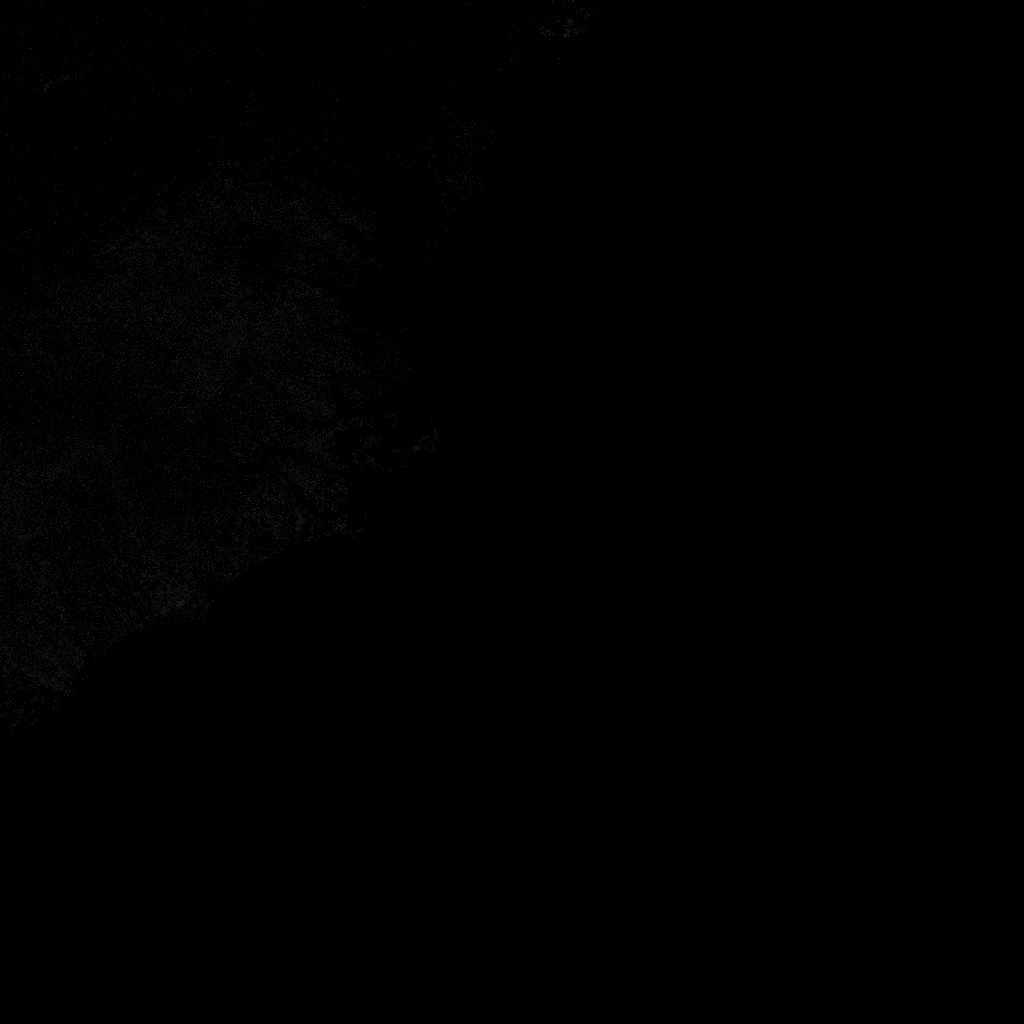

In [18]:
preview_request = httpx.get(
    f"{titiler_pgstac_endpoint}/external/preview",
    params={
        "url": cog_href,
        "maxsize": 2048,
    },
)

Image(preview_request.content)

That image is very difficult to read because titiler-pgstac does not know how to scale the values in the file to 0-255 when converting it to PNG. You can specify the min/max for the rendering with the `rescale` parameter which takes a pair of comma-separated values. This will make titiler-pgstac rescale the image values such that a value of 0 gets a 0 in the output image and a value of 24 gets 255 (for the purposes of rendering).

You can pick a colormap by name, too. `viridis` is a nice choice.

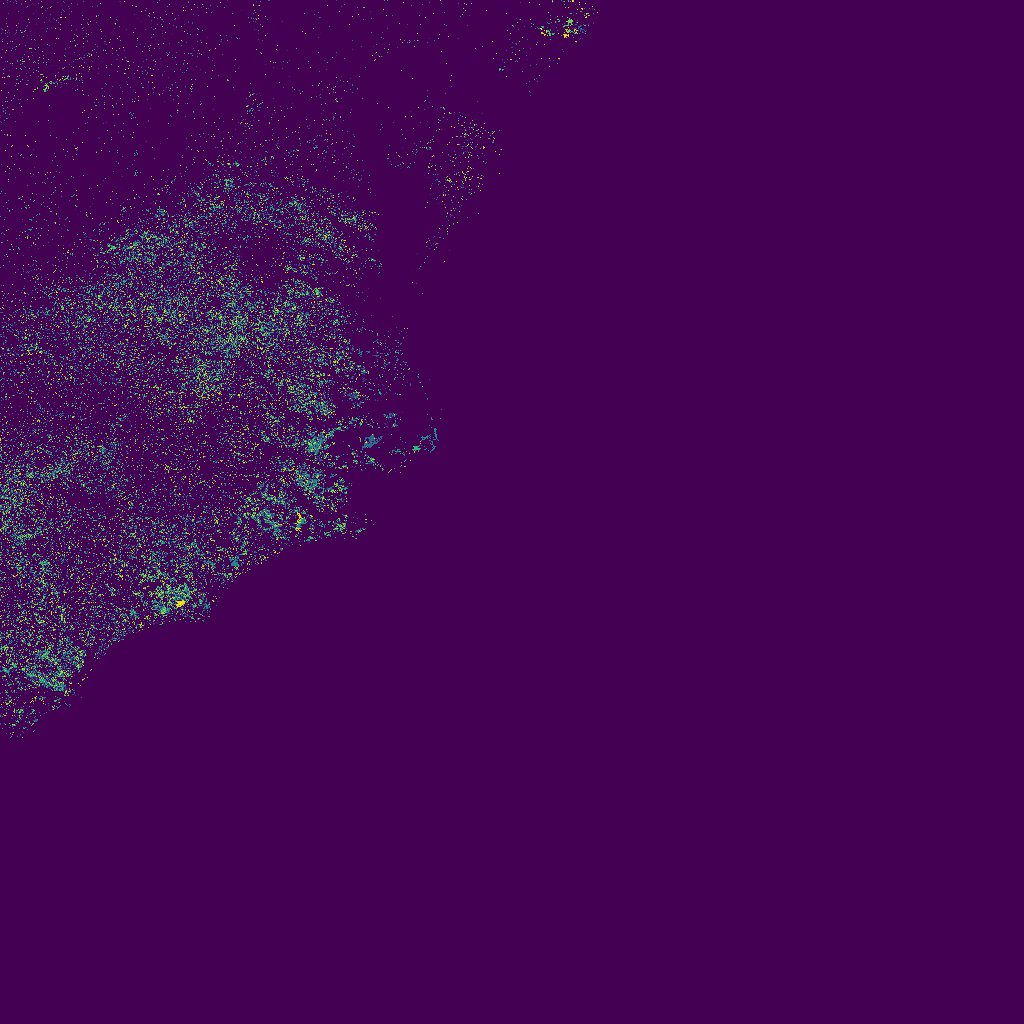

In [19]:
preview_request = httpx.get(
    f"{titiler_pgstac_endpoint}/external/preview",
    params={
        "url": cog_href,
        "maxsize": 2048,
        "colormap_name": "viridis",
        "rescale": "0,24",
    },
)

Image(preview_request.content)

That's great but what if you have a particular colormap that you want to specify for this dataset?

### 4.4.2 Manual colormaps

The file you inspected in the previous step contains information about the year in which forest cover was lost for each pixel. There is a specific color map that you want to use because it is consistent with publications that discuss the dataset.

titiler allows you to provide a colormap in JSON form but it requires some careful handling in the request. This colormap consists of `value: [r, g, b]` pairs for each unique value in the dataset. It can be passed to titiler-pgstac's `colormap` parameter by writing the dictionary to a JSON string with `json.dumps`.

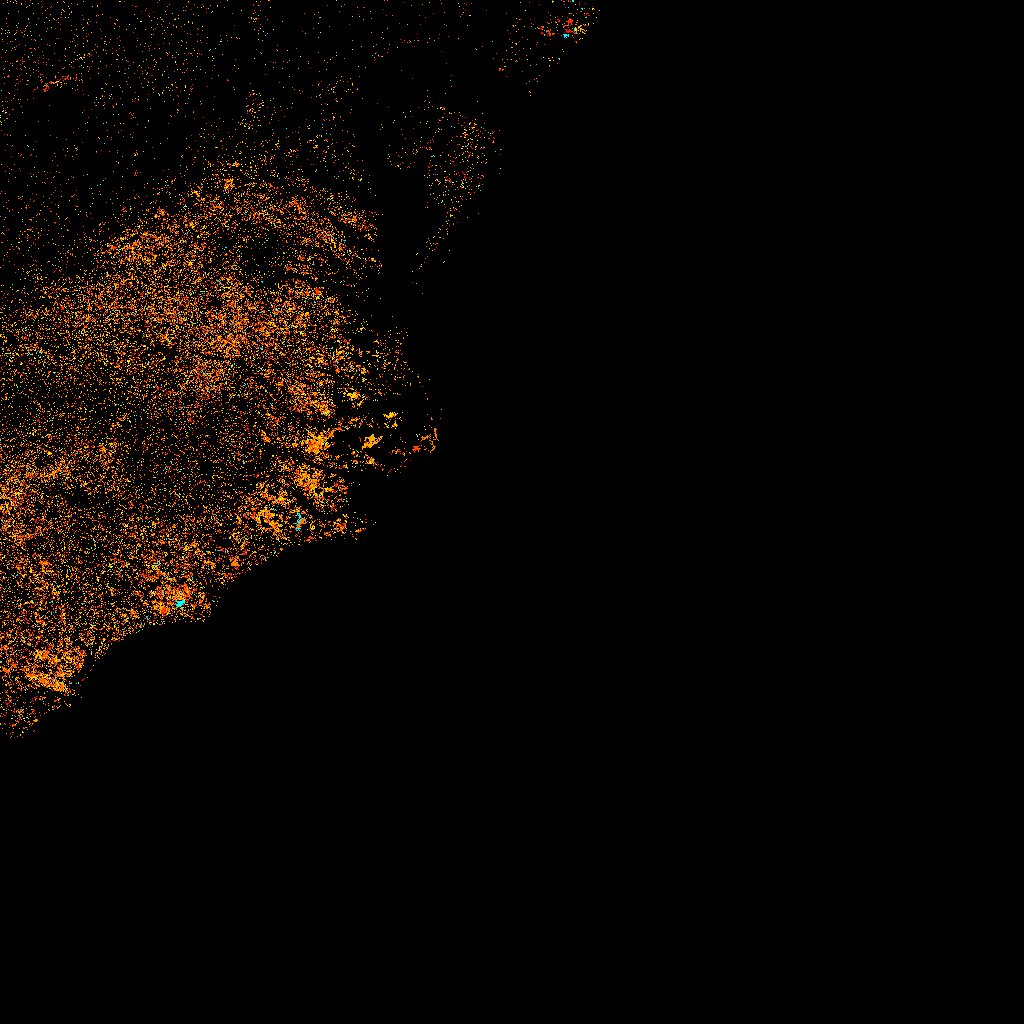

In [20]:
colormap = {
    0: [0, 0, 0],
    1: [255, 255, 0],
    2: [255, 243, 0],
    3: [255, 230, 0],
    4: [255, 217, 0],
    5: [255, 204, 0],
    6: [255, 192, 0],
    7: [255, 179, 0],
    8: [255, 166, 0],
    9: [255, 153, 0],
    10: [255, 140, 0],
    11: [255, 128, 0],
    12: [255, 116, 0],
    13: [255, 105, 0],
    14: [255, 93, 0],
    15: [255, 81, 0],
    16: [255, 70, 0],
    17: [255, 58, 0],
    18: [255, 46, 0],
    19: [255, 35, 0],
    20: [255, 23, 0],
    21: [255, 12, 0],
    22: [255, 0, 0],
    23: [0, 255, 255],
}

preview_request = httpx.get(
    f"{titiler_pgstac_endpoint}/external/preview",
    params={
        "url": cog_href,
        "maxsize": 2048,
        #
        "colormap": json.dumps({i: rgb for i, rgb in colormap.items()}),
    },
)

Image(preview_request.content)

Now that you have your colormap sorted out try rendering the image in an interactive map like the previous examples by sending a request to `/external/WebMercatorQuad/map`.

In [21]:
map_request = httpx.get(
    f"{titiler_pgstac_endpoint}/external/WebMercatorQuad/map",
    params={
        "url": cog_href,
        "maxsize": 2048,
        "colormap": json.dumps({i: rgb for i, rgb in colormap.items()}),
    },
)


IFrame(
    map_request.url,
    1200,
    800,
)

What a nice view of that cloud-optimized geotiff, right? It would be better if you could browse the entire global dataset in a map like this, though. You could do that if you loaded the dataset into your STAC!

This particular dataset is loaded in [NASA MAAP](https://maap-project.org)'s STAC and is accessible on that organization's titiler-pgstac deployment so here is a sneak peak of the global view (be patient it can take a few seconds for a titiler-pgstac running on AWS Lambda to warm up!).

In [22]:
map_request = httpx.get(
    "https://titiler-pgstac.maap-project.org/collections/glad-global-forest-change-1.11/WebMercatorQuad/map",
    params={
        "assets": "lossyear",
        "colormap": json.dumps({i: rgb for i, rgb in colormap.items()}),
    },
    timeout=None,
)


IFrame(
    map_request.url,
    1200,
    800,
)